# Uncertainty tutorial using Images
**From Colab Created by:** Akshat Sinha, Haitao Shang, Michel Atoudem Kana, Ria Cheruvu

https://colab.research.google.com/github/onefishy/am207_fall19_projects/blob/master/what_uncertainties/what_uncertainties_3/cheruvuria_136145_9127626_Final_Project_Submission.ipynb#scrollTo=KSmvrNomUkr0


### MNIST - Classification - MC Dropout
MNIST data consists of images of handwritten digits from 0 to 9 that are prelabelled as such. The training dataset consists of 60,000 images while the test data contains 10,000 images. The output vector is of shape 10x1, for the 10 classes to be predicted. It is converted to a probability vector with the softmax function.
$$y^{pred}_i = Softmax(\hat{y})$$


In [ ]:
#downgrade Tensorflow so the distribution code works, Fix THIS try the automatic script
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==1.14 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==1.14


In [ ]:
from __future__ import print_function

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import imshow
import tqdm
%matplotlib inline

import numpy as np
import pandas as pd

#import tensorflow as tf
import tensorflow.compat.v1 as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
#from tensorflow.contrib import distributions
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from itertools import product
from tensorflow.keras.regularizers import l2

In [ ]:
#Code for metrics:

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []

  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    val_targ = self.validation_data[1]
    val_f1 = f1_score(val_targ, val_predict, average='micro')
    val_recall = recall_score(val_targ, val_predict, average='micro')
    val_precision = precision_score(val_targ, val_predict, average='micro')
    self.val_f1s.append(val_f1)
    self.val_recalls.append(val_recall)
    self.val_precisions.append(val_precision)
    return

metrics = Metrics()

In [ ]:
batch_size = 128
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# add another dim to dataset for color - greyscale for MNIST would require 1 channel
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print("Input Shape", input_shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)

Input Shape (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(60000, 10)


**NOTE** Dropout Layer:
training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

So setting training=true makes the prediction/inference also use dropout
DFor more information: https://stackoverflow.com/questions/55713374/keras-how-to-use-dropout-at-train-and-test-phase


In [ ]:
def get_model(act="relu", n_hidden=[32,64,64,32], dropout_prob=0.25, loss=keras.losses.categorical_crossentropy, include_logvar=False):
    N =  input_shape[0]*input_shape[1]
    reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0
    inputs = Input(input_shape)
    inter = Dense(n_hidden[0], activation=act,
                  kernel_regularizer=l2(reg))(inputs)
    for i in range(len(n_hidden) - 1):
        inter = Dropout(dropout_prob)(inter, training=True)
        inter = Dense(n_hidden[i+1], activation=act,
                      kernel_regularizer=l2(reg))(inter)
    inter = Dropout(dropout_prob)(inter, training=True)
    inter = Flatten()(inter)
    if include_logvar:
        outputs = Dense(num_classes+1, activation=None, kernel_regularizer=l2(reg))(inter)
    else:
        outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg))(inter)

    model = Model(inputs=inputs, outputs=outputs)

    metrics = ['accuracy'] if include_logvar else ['acc',f1_m,precision_m, recall_m]
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=metrics)
    return model

In [ ]:
#Original Model no dropout_prob
orig_mnist_model = get_model(act="relu", dropout_prob=0)
orig_mnist_model.summary()
start_time = time.time()
metrics.validation_data = (x_test, y_test)
history = orig_mnist_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=15, verbose=1)
#history = orig_mnist_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=5, verbose=1, callbacks=[metrics])

mnist_orig_training_time = time.time() - start_time

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28, 28, 32)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28, 28, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 28, 28, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 28, 28, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,306 (1012.91 KB)

 Trainable params: 259,306 (1012.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - acc: 0.1439 - f1_m: 0.0000e+00 - loss: 2.2993 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.3116 - val_f1_m: 0.0000e+00 - val_loss: 2.2863 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - acc: 0.3689 - f1_m: 0.0000e+00 - loss: 2.2812 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.4941 - val_f1_m: 0.0000e+00 - val_loss: 2.2601 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.5118 - f1_m: 0.0000e+00 - loss: 2.2516 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.5889 - val_f1_m: 0.0000e+00 - val_loss: 2.2126 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - acc: 0.5932 - f1_m: 0.0000e+00 - loss: 2.1956 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6536 - val_f1_m: 0.0000e+00 - val_los

In [ ]:
#McDropout Model, to obtain epistemic/model uncertainty
mc_model = get_model(act="relu", dropout_prob=0.2)
mc_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 28, 28, 32)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 28, 28, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 28, 28, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 28, 28, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,306 (1012.91 KB)

 Trainable params: 259,306 (1012.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
metrics.validation_data = (x_test, y_test)
start_time = time.time()

#history = mc_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=5, verbose=1, callbacks=[metrics])
history = mc_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=5, verbose=1)

mnist_mc_training_time = time.time() - start_time

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.1237 - f1_m: 0.0000e+00 - loss: 2.3802 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.1983 - val_f1_m: 0.0000e+00 - val_loss: 2.3600 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - acc: 0.2553 - f1_m: 0.0000e+00 - loss: 2.3424 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.3407 - val_f1_m: 0.0000e+00 - val_loss: 2.3207 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - acc: 0.4054 - f1_m: 0.0000e+00 - loss: 2.2918 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.5134 - val_f1_m: 0.0000e+00 - val_loss: 2.2573 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.5338 - f1_m: 0.0000e+00 - loss: 2.2149 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_acc: 0.6384 - val_f1_m: 0.0000e+00 - val_loss: 

In [ ]:

mnist_mc_training_time

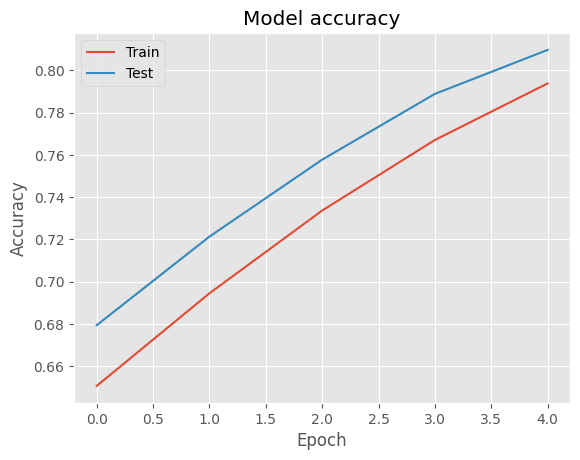

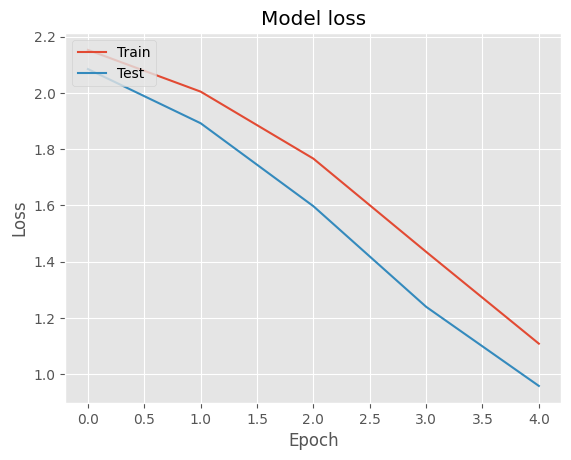

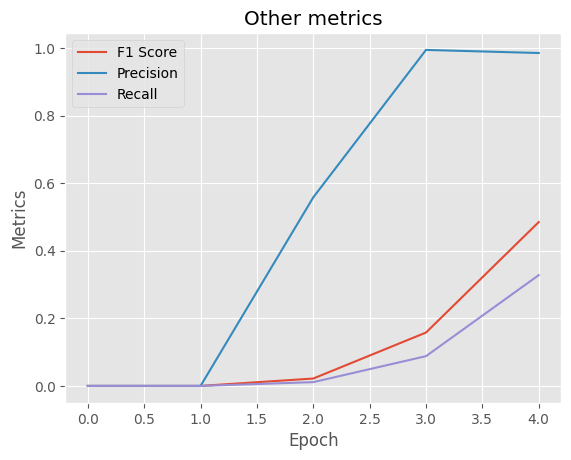

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'F1 Score'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['f1_m'])
plt.plot(history.history['precision_m'])
plt.plot(history.history['recall_m'])
plt.title('Other metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch')
plt.legend(['F1 Score', 'Precision', 'Recall'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, f1_score, precision, recall = mc_model.evaluate(x_test, y_test, verbose=0)
loss, accuracy, f1_score, precision, recall

(0.9560234546661377,
 0.8118000030517578,
 0.6239566206932068,
 0.9697719216346741,
 0.47314298152923584)

Here we sample the prediction from the MC dropout enabled model 100 times, before we take it's mean and variance as the prediction for epistemic variance.

---


NOTE:
if instead of predict use evaluate rememver to set training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

So setting training=true makes the prediction/inference also use dropout, is done already on the droplayer so is redundant here


In [ ]:
import tqdm
mc_predictions = []
for i in tqdm.tqdm(range(100)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 38ms/step


  1%|          | 1/100 [00:00<01:12,  1.37it/s]

10/10 [==============================] - 0s 38ms/step


  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

10/10 [==============================] - 0s 40ms/step


  3%|▎         | 3/100 [00:01<00:52,  1.85it/s]

10/10 [==============================] - 0s 40ms/step


  4%|▍         | 4/100 [00:02<00:58,  1.63it/s]

10/10 [==============================] - 0s 40ms/step


  5%|▌         | 5/100 [00:03<01:02,  1.53it/s]

10/10 [==============================] - 0s 37ms/step


  6%|▌         | 6/100 [00:03<00:55,  1.69it/s]

10/10 [==============================] - 0s 38ms/step


  7%|▋         | 7/100 [00:04<00:51,  1.81it/s]

10/10 [==============================] - 0s 37ms/step


  8%|▊         | 8/100 [00:04<00:55,  1.67it/s]

10/10 [==============================] - 0s 38ms/step


  9%|▉         | 9/100 [00:05<00:50,  1.80it/s]

10/10 [==============================] - 0s 37ms/step


 10%|█         | 10/100 [00:05<00:47,  1.90it/s]

10/10 [==============================] - 0s 37ms/step


 11%|█         | 11/100 [00:06<00:44,  1.99it/s]

10/10 [==============================] - 0s 37ms/step


 12%|█▏        | 12/100 [00:06<00:42,  2.07it/s]

10/10 [==============================] - 0s 37ms/step


 13%|█▎        | 13/100 [00:07<00:40,  2.13it/s]

10/10 [==============================] - 0s 37ms/step


 14%|█▍        | 14/100 [00:07<00:39,  2.17it/s]

10/10 [==============================] - 0s 37ms/step


 15%|█▌        | 15/100 [00:08<00:44,  1.90it/s]

10/10 [==============================] - 0s 37ms/step


 16%|█▌        | 16/100 [00:08<00:48,  1.74it/s]

10/10 [==============================] - 0s 37ms/step


 17%|█▋        | 17/100 [00:09<00:50,  1.63it/s]

10/10 [==============================] - 0s 38ms/step


 18%|█▊        | 18/100 [00:10<00:52,  1.57it/s]

10/10 [==============================] - 0s 37ms/step


 19%|█▉        | 19/100 [00:10<00:53,  1.52it/s]

10/10 [==============================] - 0s 37ms/step


 20%|██        | 20/100 [00:11<00:47,  1.67it/s]

10/10 [==============================] - 0s 37ms/step


 21%|██        | 21/100 [00:11<00:43,  1.82it/s]

10/10 [==============================] - 0s 37ms/step


 22%|██▏       | 22/100 [00:12<00:46,  1.69it/s]

10/10 [==============================] - 0s 37ms/step


 23%|██▎       | 23/100 [00:13<00:47,  1.61it/s]

10/10 [==============================] - 0s 39ms/step


 24%|██▍       | 24/100 [00:13<00:43,  1.74it/s]

10/10 [==============================] - 0s 39ms/step


 25%|██▌       | 25/100 [00:14<00:46,  1.62it/s]

10/10 [==============================] - 0s 41ms/step


 26%|██▌       | 26/100 [00:15<00:47,  1.55it/s]

10/10 [==============================] - 0s 38ms/step


 27%|██▋       | 27/100 [00:15<00:48,  1.49it/s]

10/10 [==============================] - 0s 37ms/step


 28%|██▊       | 28/100 [00:16<00:43,  1.65it/s]

10/10 [==============================] - 0s 37ms/step


 29%|██▉       | 29/100 [00:16<00:39,  1.78it/s]

10/10 [==============================] - 0s 37ms/step


 30%|███       | 30/100 [00:17<00:36,  1.90it/s]

10/10 [==============================] - 0s 37ms/step


 31%|███       | 31/100 [00:17<00:39,  1.74it/s]

10/10 [==============================] - 0s 38ms/step


 32%|███▏      | 32/100 [00:18<00:36,  1.86it/s]

10/10 [==============================] - 0s 37ms/step


 33%|███▎      | 33/100 [00:18<00:34,  1.97it/s]

10/10 [==============================] - 0s 37ms/step


 34%|███▍      | 34/100 [00:19<00:37,  1.78it/s]

10/10 [==============================] - 0s 38ms/step


 35%|███▌      | 35/100 [00:19<00:34,  1.90it/s]

10/10 [==============================] - 0s 37ms/step


 36%|███▌      | 36/100 [00:20<00:32,  1.98it/s]

10/10 [==============================] - 0s 37ms/step


 37%|███▋      | 37/100 [00:20<00:31,  2.03it/s]

10/10 [==============================] - 0s 37ms/step


 38%|███▊      | 38/100 [00:21<00:29,  2.07it/s]

10/10 [==============================] - 0s 37ms/step


 39%|███▉      | 39/100 [00:21<00:33,  1.82it/s]

10/10 [==============================] - 0s 37ms/step


 40%|████      | 40/100 [00:22<00:31,  1.93it/s]

10/10 [==============================] - 0s 37ms/step


 41%|████      | 41/100 [00:23<00:33,  1.76it/s]

10/10 [==============================] - 0s 37ms/step


 42%|████▏     | 42/100 [00:23<00:35,  1.66it/s]

10/10 [==============================] - 0s 38ms/step


 43%|████▎     | 43/100 [00:24<00:35,  1.59it/s]

10/10 [==============================] - 0s 37ms/step


 44%|████▍     | 44/100 [00:24<00:32,  1.74it/s]

10/10 [==============================] - 0s 38ms/step


 45%|████▌     | 45/100 [00:25<00:33,  1.63it/s]

10/10 [==============================] - 0s 40ms/step


 46%|████▌     | 46/100 [00:26<00:34,  1.54it/s]

10/10 [==============================] - 0s 39ms/step


 47%|████▋     | 47/100 [00:27<00:35,  1.48it/s]

10/10 [==============================] - 0s 38ms/step


 48%|████▊     | 48/100 [00:27<00:32,  1.60it/s]

10/10 [==============================] - 0s 37ms/step


 49%|████▉     | 49/100 [00:28<00:32,  1.56it/s]

10/10 [==============================] - 0s 37ms/step


 50%|█████     | 50/100 [00:28<00:32,  1.53it/s]

10/10 [==============================] - 0s 37ms/step


 51%|█████     | 51/100 [00:29<00:28,  1.69it/s]

10/10 [==============================] - 0s 37ms/step


 52%|█████▏    | 52/100 [00:30<00:29,  1.61it/s]

10/10 [==============================] - 0s 37ms/step


 53%|█████▎    | 53/100 [00:30<00:26,  1.77it/s]

10/10 [==============================] - 0s 37ms/step


 54%|█████▍    | 54/100 [00:31<00:27,  1.65it/s]

10/10 [==============================] - 0s 37ms/step


 55%|█████▌    | 55/100 [00:31<00:25,  1.78it/s]

10/10 [==============================] - 0s 37ms/step


 56%|█████▌    | 56/100 [00:32<00:23,  1.88it/s]

10/10 [==============================] - 0s 37ms/step


 57%|█████▋    | 57/100 [00:32<00:25,  1.72it/s]

10/10 [==============================] - 0s 37ms/step


 58%|█████▊    | 58/100 [00:33<00:22,  1.83it/s]

10/10 [==============================] - 0s 38ms/step


 59%|█████▉    | 59/100 [00:33<00:21,  1.93it/s]

10/10 [==============================] - 0s 37ms/step


 60%|██████    | 60/100 [00:34<00:22,  1.76it/s]

10/10 [==============================] - 0s 37ms/step


 61%|██████    | 61/100 [00:35<00:23,  1.66it/s]

10/10 [==============================] - 0s 38ms/step


 62%|██████▏   | 62/100 [00:35<00:21,  1.80it/s]

10/10 [==============================] - 0s 37ms/step


 63%|██████▎   | 63/100 [00:36<00:22,  1.67it/s]

10/10 [==============================] - 0s 37ms/step


 64%|██████▍   | 64/100 [00:37<00:22,  1.59it/s]

10/10 [==============================] - 0s 38ms/step


 65%|██████▌   | 65/100 [00:37<00:22,  1.54it/s]

10/10 [==============================] - 0s 40ms/step


 66%|██████▌   | 66/100 [00:38<00:22,  1.49it/s]

10/10 [==============================] - 0s 39ms/step


 67%|██████▋   | 67/100 [00:39<00:22,  1.45it/s]

10/10 [==============================] - 0s 37ms/step


 68%|██████▊   | 68/100 [00:39<00:22,  1.44it/s]

10/10 [==============================] - 0s 38ms/step


 69%|██████▉   | 69/100 [00:40<00:21,  1.45it/s]

10/10 [==============================] - 0s 37ms/step


 70%|███████   | 70/100 [00:41<00:20,  1.45it/s]

10/10 [==============================] - 0s 38ms/step


 71%|███████   | 71/100 [00:41<00:17,  1.62it/s]

10/10 [==============================] - 0s 37ms/step


 72%|███████▏  | 72/100 [00:42<00:17,  1.57it/s]

10/10 [==============================] - 0s 37ms/step


 73%|███████▎  | 73/100 [00:43<00:17,  1.52it/s]

10/10 [==============================] - 0s 37ms/step


 74%|███████▍  | 74/100 [00:43<00:15,  1.67it/s]

10/10 [==============================] - 0s 37ms/step


 75%|███████▌  | 75/100 [00:44<00:15,  1.59it/s]

10/10 [==============================] - 0s 38ms/step


 76%|███████▌  | 76/100 [00:44<00:13,  1.73it/s]

10/10 [==============================] - 0s 37ms/step


 77%|███████▋  | 77/100 [00:45<00:14,  1.62it/s]

10/10 [==============================] - 0s 37ms/step


 78%|███████▊  | 78/100 [00:45<00:12,  1.76it/s]

10/10 [==============================] - 0s 37ms/step


 79%|███████▉  | 79/100 [00:46<00:11,  1.88it/s]

10/10 [==============================] - 0s 37ms/step


 80%|████████  | 80/100 [00:46<00:10,  1.96it/s]

10/10 [==============================] - 0s 37ms/step


 81%|████████  | 81/100 [00:47<00:09,  2.05it/s]

10/10 [==============================] - 0s 37ms/step


 82%|████████▏ | 82/100 [00:47<00:09,  1.83it/s]

10/10 [==============================] - 0s 38ms/step


 83%|████████▎ | 83/100 [00:48<00:10,  1.68it/s]

10/10 [==============================] - 0s 37ms/step


 84%|████████▍ | 84/100 [00:49<00:10,  1.60it/s]

10/10 [==============================] - 0s 40ms/step


 85%|████████▌ | 85/100 [00:50<00:09,  1.53it/s]

10/10 [==============================] - 0s 39ms/step


 86%|████████▌ | 86/100 [00:50<00:09,  1.48it/s]

10/10 [==============================] - 0s 39ms/step


 87%|████████▋ | 87/100 [00:51<00:08,  1.61it/s]

10/10 [==============================] - 0s 38ms/step


 88%|████████▊ | 88/100 [00:51<00:07,  1.56it/s]

10/10 [==============================] - 0s 37ms/step


 89%|████████▉ | 89/100 [00:52<00:07,  1.53it/s]

10/10 [==============================] - 0s 38ms/step


 90%|█████████ | 90/100 [00:53<00:06,  1.50it/s]

10/10 [==============================] - 0s 37ms/step


 91%|█████████ | 91/100 [00:53<00:05,  1.66it/s]

10/10 [==============================] - 0s 37ms/step


 92%|█████████▏| 92/100 [00:54<00:05,  1.58it/s]

10/10 [==============================] - 0s 37ms/step


 93%|█████████▎| 93/100 [00:54<00:04,  1.73it/s]

10/10 [==============================] - 0s 38ms/step


 94%|█████████▍| 94/100 [00:55<00:03,  1.62it/s]

10/10 [==============================] - 0s 37ms/step


 95%|█████████▌| 95/100 [00:56<00:03,  1.55it/s]

10/10 [==============================] - 0s 37ms/step


 96%|█████████▌| 96/100 [00:56<00:02,  1.69it/s]

10/10 [==============================] - 0s 37ms/step


 97%|█████████▋| 97/100 [00:57<00:01,  1.83it/s]

10/10 [==============================] - 0s 37ms/step


 98%|█████████▊| 98/100 [00:57<00:01,  1.94it/s]

10/10 [==============================] - 0s 37ms/step


 99%|█████████▉| 99/100 [00:58<00:00,  2.02it/s]

10/10 [==============================] - 0s 37ms/step


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


In [ ]:
p = np.array(mc_predictions)
y_mean = p.mean(axis=0)
w = 1/np.sum(y_mean, axis=1).reshape(y_mean.shape[0],1)
y_mean = (y_mean*w)
y_std = p.std(axis=0)*w

In [ ]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))


MC-ensemble accuracy: 82.2%


TESTING on different Images:

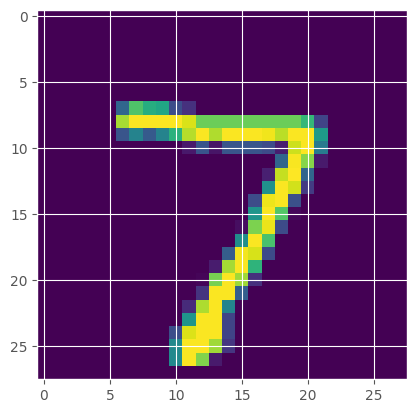

In [ ]:
#1. Image with low uncertanty
idx = 0
plt.imshow(x_test[idx][:,:,0])

In [ ]:
# p0 = np.array([p[idx] for p in mc_predictions])
print("predicted mean: {}".format(y_mean[idx].argmax(axis=0)))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
plt.errorbar(range(10), y_mean[idx], yerr=y_std[idx], linestyle='None', marker='x')
plt.plot(range(10), y_test[idx], linestyle='None', marker='o')
plt.title('True and predicted class');

NameError: ignored

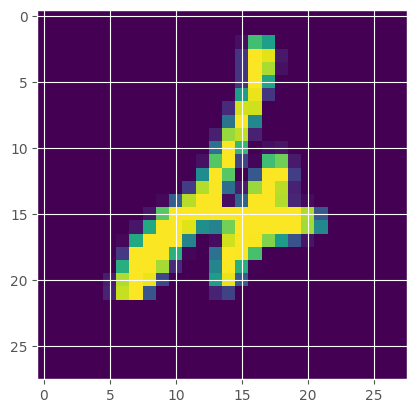

In [ ]:
#2.Image with HIgh uncertainty
idx = 247
plt.imshow(x_test[idx][:,:,0])

predicted mean: 6
true label: 4



Text(0.5, 1.0, 'True and predicted class')

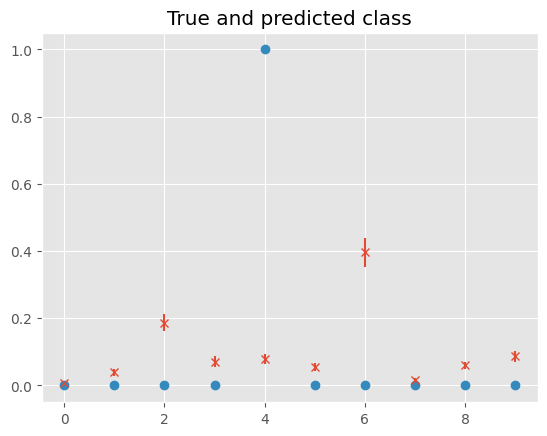

In [ ]:
# p0 = np.array([p[idx] for p in mc_predictions])
print("predicted mean: {}".format(y_mean[idx].argmax(axis=0)))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
plt.errorbar(range(10), y_mean[idx], yerr=y_std[idx], linestyle='None', marker='x')
plt.plot(range(10), y_test[idx], linestyle='None', marker='o')
plt.title('True and predicted class')

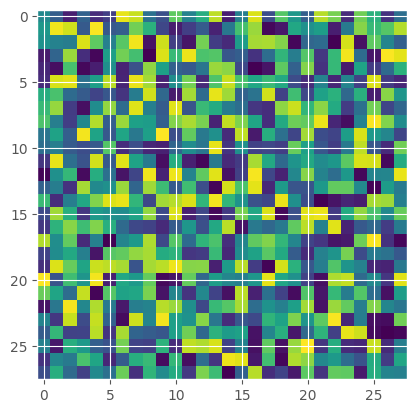

In [ ]:
#3. Image Random noise
random_img = np.random.random(input_shape)
plt.imshow(random_img[:,:,0]);
####Note: Although this results make sense, I have made contrary obervations on random
####image as well, where prediction is very confident.
####Needs to be investigated

In [ ]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/500 [00:00<00:29, 16.73it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 4/500 [00:00<00:29, 16.73it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/500 [00:00<00:29, 16.89it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 8/500 [00:00<00:29, 16.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 10/500 [00:00<00:27, 17.50it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/500 [00:00<00:27, 17.46it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 14/500 [00:00<00:27, 17.49it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 16/500 [00:00<00:27, 17.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 18/500 [00:01<00:27, 17.82it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 20/500 [00:01<00:26, 18.13it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 22/500 [00:01<00:30, 15.93it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 24/500 [00:01<00:32, 14.78it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 26/500 [00:01<00:35, 13.37it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 28/500 [00:01<00:37, 12.70it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 30/500 [00:01<00:38, 12.14it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 32/500 [00:02<00:38, 12.31it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 34/500 [00:02<00:39, 11.93it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 36/500 [00:02<00:38, 11.99it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 38/500 [00:02<00:38, 11.86it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 40/500 [00:02<00:39, 11.70it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 42/500 [00:03<00:39, 11.73it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 44/500 [00:03<00:39, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 46/500 [00:03<00:38, 11.73it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 48/500 [00:03<00:38, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 50/500 [00:03<00:34, 12.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 52/500 [00:03<00:32, 13.84it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 54/500 [00:03<00:30, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 56/500 [00:03<00:28, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 58/500 [00:04<00:27, 15.84it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 60/500 [00:04<00:26, 16.36it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 62/500 [00:04<00:26, 16.75it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 64/500 [00:04<00:26, 16.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 66/500 [00:04<00:25, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 68/500 [00:04<00:25, 16.66it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 70/500 [00:04<00:25, 16.80it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 72/500 [00:04<00:25, 16.63it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 74/500 [00:05<00:24, 17.05it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 76/500 [00:05<00:24, 17.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 78/500 [00:05<00:24, 16.95it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 80/500 [00:05<00:24, 17.03it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 82/500 [00:05<00:24, 16.98it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 84/500 [00:05<00:24, 16.67it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 86/500 [00:05<00:24, 16.93it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 88/500 [00:05<00:25, 16.21it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 90/500 [00:06<00:25, 16.29it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 92/500 [00:06<00:26, 15.67it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 94/500 [00:06<00:25, 15.76it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 96/500 [00:06<00:24, 16.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 98/500 [00:06<00:24, 16.44it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 100/500 [00:06<00:24, 16.32it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 102/500 [00:06<00:24, 16.47it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 104/500 [00:06<00:24, 16.28it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 106/500 [00:07<00:24, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 108/500 [00:07<00:23, 16.47it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 110/500 [00:07<00:23, 16.60it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 112/500 [00:07<00:23, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 114/500 [00:07<00:23, 16.50it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 116/500 [00:07<00:23, 16.26it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 118/500 [00:07<00:22, 16.62it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 120/500 [00:07<00:22, 16.82it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 122/500 [00:07<00:22, 16.47it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 124/500 [00:08<00:23, 16.19it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 126/500 [00:08<00:22, 16.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 128/500 [00:08<00:22, 16.79it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 130/500 [00:08<00:22, 16.75it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 132/500 [00:08<00:22, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 134/500 [00:08<00:22, 16.57it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 136/500 [00:08<00:22, 16.45it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 138/500 [00:08<00:22, 16.11it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 140/500 [00:09<00:21, 16.63it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 142/500 [00:09<00:21, 16.56it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 144/500 [00:09<00:21, 16.42it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 146/500 [00:09<00:21, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 148/500 [00:09<00:21, 16.44it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 150/500 [00:09<00:21, 16.47it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 152/500 [00:09<00:21, 16.57it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 154/500 [00:09<00:20, 16.84it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 156/500 [00:10<00:20, 16.48it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 158/500 [00:10<00:20, 16.81it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 160/500 [00:10<00:20, 16.59it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 162/500 [00:10<00:20, 16.84it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 164/500 [00:10<00:19, 17.03it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 166/500 [00:10<00:19, 16.72it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 168/500 [00:10<00:19, 16.62it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 170/500 [00:10<00:19, 16.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 172/500 [00:11<00:20, 16.32it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 174/500 [00:11<00:19, 16.67it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 176/500 [00:11<00:19, 16.88it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 178/500 [00:11<00:19, 16.82it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 180/500 [00:11<00:18, 16.93it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 182/500 [00:11<00:18, 16.93it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 184/500 [00:11<00:19, 15.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 186/500 [00:11<00:19, 15.87it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 188/500 [00:11<00:19, 15.91it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 190/500 [00:12<00:19, 15.66it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 192/500 [00:12<00:19, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 194/500 [00:12<00:18, 16.32it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 196/500 [00:12<00:18, 16.31it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 198/500 [00:12<00:18, 16.49it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 200/500 [00:12<00:18, 16.47it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 202/500 [00:12<00:17, 16.59it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 204/500 [00:12<00:18, 16.35it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 206/500 [00:13<00:17, 16.44it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 208/500 [00:13<00:18, 16.14it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 210/500 [00:13<00:17, 16.43it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 212/500 [00:13<00:17, 16.32it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 214/500 [00:13<00:18, 15.62it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 216/500 [00:13<00:20, 13.98it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 218/500 [00:13<00:20, 13.48it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 220/500 [00:14<00:22, 12.30it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 222/500 [00:14<00:23, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 224/500 [00:14<00:23, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 226/500 [00:14<00:23, 11.77it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 228/500 [00:14<00:23, 11.67it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 230/500 [00:14<00:23, 11.58it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 232/500 [00:15<00:22, 11.77it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 234/500 [00:15<00:23, 11.53it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 236/500 [00:15<00:22, 11.50it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 238/500 [00:15<00:23, 11.22it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 240/500 [00:15<00:23, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 242/500 [00:16<00:20, 12.39it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 244/500 [00:16<00:19, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 246/500 [00:16<00:18, 13.85it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 248/500 [00:16<00:17, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 250/500 [00:16<00:16, 15.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 252/500 [00:16<00:15, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 254/500 [00:16<00:15, 15.75it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 256/500 [00:16<00:14, 16.35it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 258/500 [00:16<00:14, 16.50it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 260/500 [00:17<00:14, 16.38it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 262/500 [00:17<00:14, 16.33it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 264/500 [00:17<00:14, 16.34it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 266/500 [00:17<00:14, 16.63it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 268/500 [00:17<00:13, 16.81it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 270/500 [00:17<00:13, 16.56it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 272/500 [00:17<00:13, 16.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 274/500 [00:17<00:13, 16.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 276/500 [00:18<00:13, 16.92it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 278/500 [00:18<00:13, 16.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 280/500 [00:18<00:13, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 282/500 [00:18<00:13, 16.07it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 284/500 [00:18<00:13, 16.07it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 286/500 [00:18<00:13, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 288/500 [00:18<00:12, 16.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 290/500 [00:18<00:12, 16.63it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 292/500 [00:19<00:12, 16.73it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 294/500 [00:19<00:12, 16.48it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 296/500 [00:19<00:12, 16.42it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 298/500 [00:19<00:12, 16.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 300/500 [00:19<00:12, 16.48it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 302/500 [00:19<00:12, 16.25it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 304/500 [00:19<00:12, 15.79it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 306/500 [00:19<00:12, 15.88it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 308/500 [00:20<00:11, 16.22it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 310/500 [00:20<00:11, 15.92it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 312/500 [00:20<00:11, 16.12it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 314/500 [00:20<00:11, 16.19it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 316/500 [00:20<00:11, 16.31it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 318/500 [00:20<00:11, 15.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 320/500 [00:20<00:11, 15.52it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 322/500 [00:20<00:11, 15.24it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 324/500 [00:21<00:11, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 326/500 [00:21<00:11, 15.59it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 328/500 [00:21<00:11, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 330/500 [00:21<00:10, 15.63it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 332/500 [00:21<00:10, 15.82it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 334/500 [00:21<00:10, 15.99it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 336/500 [00:21<00:10, 16.19it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 338/500 [00:21<00:10, 16.17it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 340/500 [00:22<00:09, 16.47it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 342/500 [00:22<00:09, 16.83it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 344/500 [00:22<00:09, 16.49it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 346/500 [00:22<00:09, 15.75it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 348/500 [00:22<00:09, 16.29it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 350/500 [00:22<00:09, 16.43it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 352/500 [00:22<00:09, 16.27it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 354/500 [00:22<00:08, 16.56it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 356/500 [00:23<00:08, 16.66it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 358/500 [00:23<00:08, 15.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 360/500 [00:23<00:08, 16.45it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 362/500 [00:23<00:08, 16.49it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 364/500 [00:23<00:17,  7.79it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 366/500 [00:24<00:14,  9.16it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 368/500 [00:24<00:12, 10.37it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 370/500 [00:24<00:11, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 372/500 [00:24<00:10, 12.42it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 374/500 [00:24<00:09, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 376/500 [00:24<00:09, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 378/500 [00:24<00:08, 13.85it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 380/500 [00:25<00:08, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 382/500 [00:25<00:08, 14.31it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 384/500 [00:25<00:07, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 386/500 [00:25<00:07, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 388/500 [00:25<00:07, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 390/500 [00:25<00:07, 14.56it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 392/500 [00:25<00:07, 14.75it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 394/500 [00:25<00:07, 13.88it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 396/500 [00:26<00:08, 12.16it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 398/500 [00:26<00:08, 11.73it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 400/500 [00:26<00:08, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 402/500 [00:26<00:08, 11.46it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 404/500 [00:26<00:08, 11.21it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 406/500 [00:27<00:08, 11.33it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 408/500 [00:27<00:08, 11.05it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 410/500 [00:27<00:08, 10.82it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 412/500 [00:27<00:08, 10.76it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 414/500 [00:27<00:07, 10.97it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 416/500 [00:28<00:07, 11.16it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▎ | 418/500 [00:28<00:07, 10.91it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 420/500 [00:28<00:07, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 422/500 [00:28<00:06, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 424/500 [00:28<00:05, 13.10it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 426/500 [00:28<00:05, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 428/500 [00:28<00:05, 13.97it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 430/500 [00:29<00:04, 14.42it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 432/500 [00:29<00:04, 15.07it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 434/500 [00:29<00:04, 15.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 436/500 [00:29<00:04, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 438/500 [00:29<00:04, 15.38it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 440/500 [00:29<00:03, 15.65it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 442/500 [00:29<00:03, 15.60it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 444/500 [00:29<00:03, 15.65it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 446/500 [00:30<00:03, 15.68it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 448/500 [00:30<00:03, 15.89it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 450/500 [00:30<00:03, 16.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 452/500 [00:30<00:03, 15.93it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 454/500 [00:30<00:02, 15.53it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 456/500 [00:30<00:02, 15.65it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 458/500 [00:30<00:02, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 460/500 [00:30<00:02, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 462/500 [00:31<00:02, 15.78it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 464/500 [00:31<00:02, 15.98it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 466/500 [00:31<00:02, 15.93it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 468/500 [00:31<00:02, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 470/500 [00:31<00:01, 15.49it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 472/500 [00:31<00:01, 15.19it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 474/500 [00:31<00:01, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 476/500 [00:31<00:01, 15.81it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 478/500 [00:32<00:01, 16.08it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 480/500 [00:32<00:01, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 482/500 [00:32<00:01, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 484/500 [00:32<00:00, 16.03it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 486/500 [00:32<00:00, 15.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 488/500 [00:32<00:00, 16.01it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 490/500 [00:32<00:00, 15.67it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 492/500 [00:32<00:00, 15.99it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 494/500 [00:33<00:00, 16.29it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 496/500 [00:33<00:00, 16.37it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 498/500 [00:33<00:00, 16.31it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 500/500 [00:33<00:00, 14.94it/s]


In [ ]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 2

class: 0; proba: 12.7%; var: 3.93% 
class: 1; proba: 0.2%; var: 0.08% 
class: 2; proba: 24.7%; var: 5.92% 
class: 3; proba: 12.2%; var: 3.31% 
class: 4; proba: 6.5%; var: 2.13% 
class: 5; proba: 22.4%; var: 5.06% 
class: 6; proba: 4.9%; var: 1.64% 
class: 7; proba: 3.7%; var: 1.37% 
class: 8; proba: 9.2%; var: 2.60% 
class: 9; proba: 3.5%; var: 1.03% 


<ErrorbarContainer object of 3 artists>

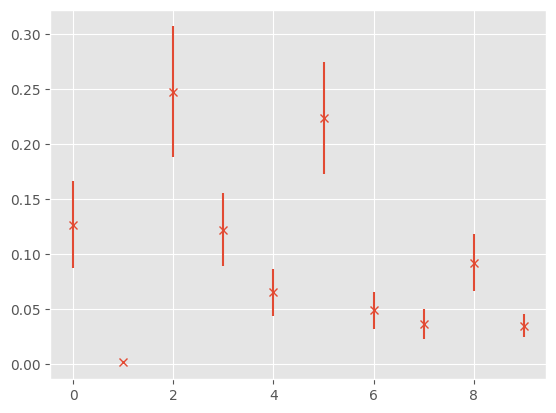

In [ ]:
plt.errorbar(range(10), p0.mean(axis=0), yerr=p0.std(axis=0), ls='None', marker='x')

### Aleatoric Uncertainty

In [ ]:
num_classes=10

def softmax(pred):
  return K.exp(pred - K.log(K.sum(K.exp(pred))))  # numerically stable softmax

def softmax_np(pred):
  return np.exp(pred - np.log(np.sum(np.exp(pred), axis=1)).reshape(pred.shape[0],1))

def gaussian_softmax(ypred, dist, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    distorted_loss = softmax(ypred + std_samples)
    return distorted_loss
  return map_fn

def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    #dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    dist = tfd.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')

    variance_loss = K.categorical_crossentropy(ytrue, K.mean(monte_carlo_results, axis=0))

    return variance_loss

  return bayesian_categorical_crossentropy_internal

def simple_bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
  #A slight modification to the original fuction for the simple example
    std = K.exp(0.5*ypred_var[:, num_classes:])
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(30))
    #iterable = K.variable(np.ones(T))
    dist = tfd.Normal(loc=K.zeros_like(std), scale=std)
    #dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')

    #predictions = K.categorical_crossentropy(ytrue, y_pred)
    predictions = K.categorical_crossentropy(ytrue, monte_carlo_results)


    return predictions

In [ ]:
loss_fn = bayesian_categorical_crossentropy(T=30, num_classes=num_classes)
#loss_fn = simple_bayesian_categorical_crossentropy_internal(y_test,mc_ensemble_pred)

In [ ]:
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    #dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    dist = tfd.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')

    # Calculate mean and squeeze the extra dimension
    mean_monte_carlo_results = K.squeeze(K.mean(monte_carlo_results, axis=0), axis=0)

    variance_loss = K.categorical_crossentropy(ytrue, mean_monte_carlo_results)

    return variance_loss

  return bayesian_categorical_crossentropy_internal

In [ ]:
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    #dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    dist = tfd.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')

    # Calculate mean and squeeze the extra dimension
    mean_monte_carlo_results = K.squeeze(K.mean(monte_carlo_results, axis=0), axis=0)

    variance_loss = K.categorical_crossentropy(ytrue, mean_monte_carlo_results)

    return variance_loss

  return bayesian_categorical_crossentropy_internal

In [ ]:
aleatoric_model = get_model(act="relu", dropout_prob=0, loss=loss_fn, include_logvar=True)
aleatoric_model.summary()

start_time = time.time()
a_m = aleatoric_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    )
mnist_aleatoric_training_time = time.time() - start_time

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 28, 28, 32)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 28, 28, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 28, 28, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 28, 28, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 11)                  │         275,979 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 284,395 (1.08 MB)

 Trainable params: 284,395 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Shapes (None, 10) and (1, None, 10) are incompatible

**Combining** Aleatoric and Epistemic Combined


---

CHANGE THIS PART SO IS MORE CONCISE AND EVALUATES IMAGES ONE by ONE
Next, we train the model with MC dropout and the heteroscedastic loss:

In [ ]:
total_mc_model = get_model(act="relu", dropout_prob=0.2, loss=loss_fn, include_logvar=True)
total_mc_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dense_35 (Dense)            (None, 28, 28, 32)        64        
                                                                 
 dropout_28 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 dense_36 (Dense)            (None, 28, 28, 64)        2112      
                                                                 
 dropout_29 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 dense_37 (Dense)            (None, 28, 28, 64)        4160      
                                                                 
 dropout_30 (Dropout)        (None, 28, 28, 64)        0   

In [ ]:
start_time = time.time()

c_mc = total_mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    )
mnist_total_model_training_time = time.time() - start_time

Epoch 1/20


ValueError: ignored

Here we sample the prediction from the MC dropout enabled model 100 times, before we take it's mean and variance as the prediction and epistemic variance.

In [ ]:
import tqdm
mc_predictions = []
for i in tqdm.tqdm(range(100)):
    y_p = total_mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 100/100 [35:10<00:00, 21.11s/it]


In [ ]:
def softmax_np(pred):
  # numerically stable cross entropy
  return np.exp(pred - np.log(np.sum(np.exp(pred), axis=2)).reshape(pred.shape[0],pred.shape[1],1))

p = np.array(mc_predictions)
pred = softmax_np(p[:,:,:num_classes])
y_mean = pred.mean(axis=0)
aleatoric_std = np.exp(0.5*p[:, :, num_classes:].mean(axis=0))
y_mean = y_mean[:,0:num_classes]
w = 1/np.sum(y_mean, axis=1).reshape(p.shape[1],1)
y_mean = (y_mean*w)
epistemic_std = p[:,:,0:num_classes].mean(axis=0).std(axis=1)

We find that the averaged prediction vector from the MC dropout enabled model has a higher accuracy than the best single prediction vector.

MC-ensemble accuracy: 88.3%


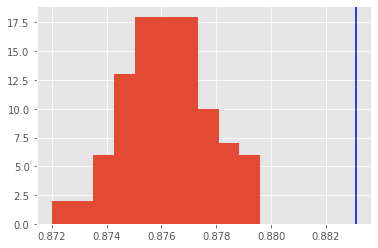

In [ ]:
pred = np.array(mc_predictions)
mc_ensemble_pred =pred[:,:,:num_classes].mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

plt.hist([accuracy_score(pred[i,:,:num_classes].argmax(axis=1), y_test.argmax(1)) for i in range(100)])
plt.axvline(x=ensemble_acc, color='blue')

SUMARY of the COMBINED Uncertainty

In [ ]:
def train_mc_model(x_train, y_train, epochs=10, T=30, verbose=1):
  loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)
  mc_model = get_model(act="relu", dropout_prob=0.2, loss=loss_fn, include_logvar=True)
  mc_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test)
              )
  return mc_model

def predict_model(model, x_test, T=30):
  mc_predictions = []
  for i in range(T):
    y_p = model.predict(x_test)
    mc_predictions.append(y_p)

  p = np.array(mc_predictions)
  pred = softmax_np(p[:,:,:num_classes])
  y_mean = pred.mean(axis=0)
  aleatoric_std = np.exp(0.5*p[:, :, num_classes:])
  y_mean = y_mean[:,0:num_classes]
  w = 1/np.sum(y_mean, axis=1).reshape(p.shape[1],1)
  y_mean = (y_mean*w)
  epistemic_std = pred[:,:,0:num_classes].std(axis=0)
  return y_mean, aleatoric_std, epistemic_std


In [ ]:
mc_model = train_mc_model(x_train, y_train, epochs=20, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 182s 3ms/sample - loss: 2.4041 - acc: 0.1561 - val_loss: 2.3921 - val_acc: 0.2290
Epoch 2/20
60000/60000 [==============================] - 180s 3ms/sample - loss: 2.3769 - acc: 0.2999 - val_loss: 2.3538 - val_acc: 0.3667
Epoch 3/20
60000/60000 [==============================] - 180s 3ms/sample - loss: 2.3373 - acc: 0.4208 - val_loss: 2.3093 - val_acc: 0.4748
Epoch 4/20
60000/60000 [==============================] - 180s 3ms/sample - loss: 2.2774 - acc: 0.5171 - val_loss: 2.2336 - val_acc: 0.5654
Epoch 5/20
60000/60000 [==============================] - 179s 3ms/sample - loss: 2.1779 - acc: 0.6010 - val_loss: 2.0973 - val_acc: 0.6502
Epoch 6/20
60000/60000 [==============================] - 182s 3ms/sample - loss: 2.0026 - acc: 0.6771 - val_loss: 1.8676 - val_acc: 0.7195
Epoch 7/20
60000/60000 [==============================] - 185s 3ms/sample - loss: 1.7138 - acc: 0.7353 - val_l

In [ ]:
#runtime_df = pd.DataFrame({'Model':['Original model', 'Model with epistemic uncertainity', 'Model with aleatoric uncertainity', 'Model with epistemic and aleatoric uncertainity'], 'Training time (in seconds)':[mnist_orig_training_time, mnist_mc_training_time, mnist_aleatoric_training_time, mnist_total_model_training_time]})
#runtime_df


Now Predict the previous combined model and print some of the cases like above